In [21]:
from helperFunctions import *
from constants import *

In [4]:
'''
Files that work with this notebook: 
participant_P004_exp001_block_full_start.xdf # full start
participant_P004_exp002_block_full_start.xdf # This should work: after restarting computer
participant_P004_exp003_block_full_start.xdf # This should work too
participant_P004_exp001_block_full_short.xdf # Works
participant_P004_exp001_block_full_long.xdf # Works

'''

XDF_Data = loadxdf("../data/participant_P004_exp001_block_full_long.xdf")
if StreamType.EEG.value in XDF_Data : 
    eeg_fs = int(XDF_Data[StreamType.EEG.value][StreamType.FS.value])

# Trim the data to only include the time PsychoPy was running
XDF_Data = epochByMarkIndex(0, -1, XDF_Data)

# Check if all markers are in the data
all_markers = np.array(XDF_Data[StreamType.MARKER.value][StreamType.DATA.value][:,0])
markersFound = True
for marker_key in PSYCHO_PY_MARKERS : 
    if PSYCHO_PY_MARKERS[marker_key] not in all_markers: 
        markersFound = False 
        print("Missing Marker:", PSYCHO_PY_MARKERS[marker_key])
print("All Markers Found?", markersFound)

Missing Marker: --InstructionStart
Missing Marker: --InstructionStop
Missing Marker: --LettersShown
All Markers Found? False


In [5]:
# Get all the marker indexes in dictionary form
def getMarkerIndexes(original_data=XDF_Data):
    markers = np.array(original_data[StreamType.MARKER.value][StreamType.DATA.value][:,0])
    marker_indexes = {}
    for index, marker in enumerate(markers): 
        if marker not in marker_indexes:
            marker_indexes[marker] = list()
        marker_indexes[marker].append(index)
    return marker_indexes

## Get marker strings


In [6]:
def getSectionMarkerString(section_name):
    return "--"+section_name.capitalize()+"Start", "--"+section_name.capitalize()+"Stop"

def getSingleLabelMarkerString(label_name):
    return "--"+label_name[0].capitalize()+label_name[1:]

def getResponseLabelMarkerString(label_name):
    return "--"+label_name.capitalize()+"Response"

def getLabelMarkerString(label_name):
    marker = ""
    if label_name in SINGLE_LABELS:
        marker = getSingleLabelMarkerString(label_name)
    elif label_name in RESPONSE_LABELS: 
        marker = getResponseLabelMarkerString(label_name)
    else : 
        print(label_name + " not a valid label")
    return marker

In [7]:
def getPreviousLabelIndex(label_to_find, max_index, original_data=XDF_Data): 
    index = max_index
    while(index >= 0):
        if original_data[StreamType.MARKER.value][StreamType.DATA.value][index] == label_to_find:
            return index
        index -= 1
    return -1

In [8]:
def getNextLabelIndex(label_to_find, min_index, original_data=XDF_Data): 
    index = min_index
    while(index < len(XDF_Data[StreamType.MARKER.value][StreamType.DATA.value])):
        if original_data[StreamType.MARKER.value][StreamType.DATA.value][index] == label_to_find:
            return index
        index += 1
    return -1

## Get data sections


In [9]:
# Get all of a single section's data given the single section name
def getSectionData(section_name, original_data=XDF_Data) :
    if section_name not in SINGLETON_SECTIONS: 
        print(section_name, " not a singleton section")
        return epochByMarkIndex(0, 0, original_data)
    start_marker, stop_marker = getSectionMarkerString(section_name)
    marker_indexes = getMarkerIndexes(original_data) 
    if start_marker not in marker_indexes or stop_marker not in marker_indexes : 
        return epochByMarkIndex(0, 0, original_data)
    return epochByMarkIndex(marker_indexes[start_marker][0], marker_indexes[stop_marker][0], original_data)
    

# Return the article section data given the section_name and article number 
def getArticleSectionData(section_name, article_number, original_data=XDF_Data):
    if section_name not in ARTICLE_SECTIONS: 
        print(section_name, " not an article section")
        return epochByMarkIndex(0, 0, original_data)
    start_marker, stop_marker = getSectionMarkerString(section_name)
    marker_indexes = getMarkerIndexes(original_data) 
    if start_marker not in marker_indexes or stop_marker not in marker_indexes : 
        return epochByMarkIndex(0, 0, original_data)
    return epochByMarkIndex(marker_indexes[start_marker][article_number], marker_indexes[stop_marker][article_number], original_data)

# Returns all the single label data in the original data
# time_before and time_after: the number of seconds before and after each marker to return 
# Returns a list of all the data with time_before and time_after
def getTimeBoundSingleLabelData(label_name, time_before=2, time_after=2, original_data=XDF_Data):
    marker_indexes = getMarkerIndexes(original_data)
    marker = getLabelMarkerString(label_name)
    if label_name == "":
        print(label_name + " not a valid label")
        return [], [], []
    
    if marker not in marker_indexes: 
        return [], [], []
    sub_markers_indexes = marker_indexes[marker]
    sub_markers_times = list()
    data = list()
    for sub_markers_index in sub_markers_indexes:
        sub_markers_time = original_data[StreamType.MARKER.value][StreamType.TIME.value][sub_markers_index]
        sub_markers_times.append(sub_markers_time)
        start_time = sub_markers_time - time_before
        end_time = sub_markers_time + time_after
        data.append(epochByTime(start_time, end_time, original_data))
    return data, sub_markers_indexes, sub_markers_times

# primary_label_name is the primary label to look for. secondary_label_name is the secondary label to help bound the primary label in the front or the back. 
def getLabelBoundSingleLabelData(primary_label_name, secondary_label_name, original_data=XDF_Data, go_backward=True):
    marker_indexes = getMarkerIndexes(original_data)
    marker_primary = getLabelMarkerString(primary_label_name)
    if primary_label_name == "":
        return [], [], []
    
    marker_secondary = getLabelMarkerString(secondary_label_name)
    if secondary_label_name == "":
        return [], [], []
    
    if marker_secondary not in marker_indexes or marker_primary not in marker_indexes: 
        return [], [], []
    
    return getMarkerBoundSingleMarkerData(marker_primary, marker_secondary, original_data, go_backward=go_backward)

def getMarkerBoundSingleMarkerData(marker_primary, marker_secondary, original_data=XDF_Data, go_backward=True):
    marker_indexes = getMarkerIndexes(original_data)
    sub_markers_indexes = marker_indexes[marker_primary]
    sub_markers_secondary_indexes = list()
    data = list()
    for sub_markers_index in sub_markers_indexes:
        if go_backward:
            secondary_index = getPreviousLabelIndex(marker_secondary, sub_markers_index, original_data)
            data.append(epochByMarkIndex(secondary_index, sub_markers_index, original_data))
        else :
            secondary_index = getNextLabelIndex(marker_secondary, sub_markers_index, original_data)
            data.append(epochByMarkIndex(sub_markers_index, secondary_index, original_data))
        
        sub_markers_secondary_indexes.append(secondary_index)
    return data, sub_markers_indexes, sub_markers_secondary_indexes
        

In [10]:
def getNumSections(original_data=XDF_Data):
    return len(getMarkerIndexes(XDF_Data)[getSingleLabelMarkerString("newArticle")])
print("num sections",getNumSections() )

num sections 5


In [11]:
def getNumDistractions(original_data=XDF_Data):
    marker_indexes = getMarkerIndexes(original_data)
    marker_string = getLabelMarkerString("lettersShown")
    if marker_string not in marker_indexes: 
        return 0 
    return len(marker_indexes[marker_string])

In [12]:
def getWordLengths(original_data=XDF_Data): 
    marker_indexes = getMarkerIndexes(original_data)
    marker_string = getLabelMarkerString("newWord")
    if marker_string not in marker_indexes: 
        return []
    word_lengths = list() 
    for index in marker_indexes[marker_string] : 
        word_index = index + 2
        word = original_data[StreamType.MARKER.value][StreamType.DATA.value][word_index]
        print(word)
        word_lengths.append(len(word[0]))
    return word_lengths

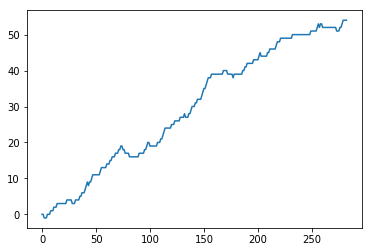

In [13]:
def getPointsAfterEachWord(original_data=XDF_Data): 
    marker_indexes = getMarkerIndexes(original_data)
    marker_string = getLabelMarkerString("endWord")
    if marker_string not in marker_indexes: 
        return []
    points_list = list() 
    for index in marker_indexes[marker_string] : 
        point_index = index - 1
        point = int(original_data[StreamType.MARKER.value][StreamType.DATA.value][point_index])
        points_list.append(point)
    return points_list

plt.plot(getPointsAfterEachWord())
plt.show()

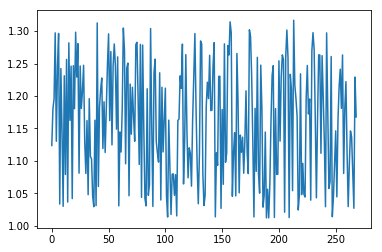

In [14]:
def getElapsedTimeOfSection(original_data=XDF_Data):
    return original_data[StreamType.MARKER.value][StreamType.TIME.value][-1] - original_data[StreamType.MARKER.value][StreamType.TIME.value][0]

correct_response_data, indx_p, indx_s = getLabelBoundSingleLabelData("correct", "newWord")
reaction_times = list()
for data in correct_response_data:
    reaction_times.append(getElapsedTimeOfSection(data))
plt.plot(reaction_times)
plt.show()

In [15]:
def getTotalPoints(original_data=XDF_Data):
    marker_indexes = getMarkerIndexes(original_data)
    start_marker_string = getLabelMarkerString("newWord")
    end_marker_string = getLabelMarkerString("endWord")
    start_points = int(original_data[StreamType.MARKER.value][StreamType.DATA.value][marker_indexes[start_marker_string][0] + 1])
    end_points = int(original_data[StreamType.MARKER.value][StreamType.DATA.value][marker_indexes[end_marker_string][-1] - 1])
    delta_points = end_points - start_points
    return delta_points
print("total points", getTotalPoints(getArticleSectionData("response", 3)))   

total points 21


In [16]:
def getNumWords(original_data=XDF_Data): 
    marker_indexes = getMarkerIndexes(original_data)
    return len(marker_indexes[getLabelMarkerString("newWord")])
print("num words:", getNumWords())

num words: 283


In [17]:
def getNumTargetWords(original_data=XDF_Data):
    marker_indexes = getMarkerIndexes(original_data)
    return len(marker_indexes[getLabelMarkerString("targetWord")])
print("num target words:", getNumTargetWords())

num target words: 75


In [18]:
# Returns an array of 1 or 0 to represent whether that ith word was a target word
def getWordType(original_data=XDF_Data):
    marker_indexes = getMarkerIndexes(original_data)
    new_word_indexes = marker_indexes[getLabelMarkerString("newWord")]
    word_type_indexes = [0] * len(new_word_indexes)
    target_word_indexes = marker_indexes[getLabelMarkerString("targetWord")]
    count=0
    for i, val in enumerate(word_type_indexes) : 
        if new_word_indexes[i]+4 in target_word_indexes: 
            count+=1
            word_type_indexes[i] = 1
    return word_type_indexes

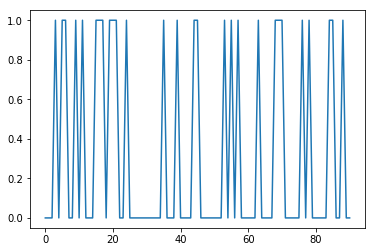

In [19]:
plt.plot(getWordType(getArticleSectionData("response", 3)))